<a href="https://colab.research.google.com/github/mmasdar/end-to-end-dental-disease/blob/main/Ensemble_DL_Model_for_Dental_Diagnosis_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Dataset
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Generate Blurr Image as Input

Blurred image saved successfully at: /content/blurred_image_rgb.jpg


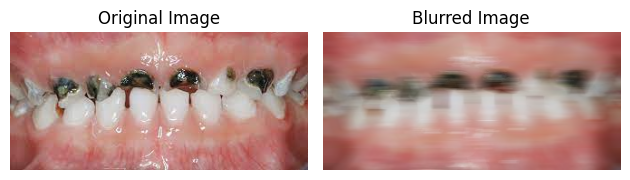

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def motion_blur_horizontal(image, kernel_size):
    # Create the horizontal kernel.
    kernel_h = np.zeros((kernel_size, kernel_size))
    # Fill the middle row with ones.
    kernel_h[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    # Normalize.
    kernel_h /= kernel_size

    # Perform convolution using the horizontal kernel.
    blurred_image = cv2.filter2D(image, -1, kernel_h)

    return blurred_image

# Load the original image
image = cv2.imread('/content/10.jpg')

# Specify the kernel size for motion blur
kernel_size = 20

# Perform motion blur in the horizontal direction
blurred_image = motion_blur_horizontal(image, kernel_size)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the blurred image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the blurred image
output_path = '/content/blurred_image_rgb.jpg'
cv2.imwrite(output_path, blurred_image)
print(f"Blurred image saved successfully at: {output_path}")

# Show the plot
plt.show()

## System for X-ray

1/1 [==============================] - 3s 3s/step


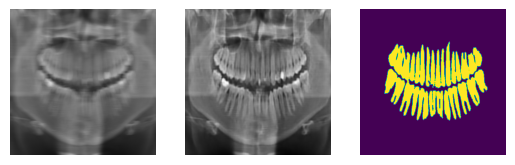

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

class ImageProcessor:
    def __init__(self, pix2pix_model_path, segmentation_model_path):
        self.pix2pix_model = keras.models.load_model(pix2pix_model_path)
        self.segmentation_model = self.load_segmentation_model(segmentation_model_path)

    @staticmethod
    def preprocess_input(input_image):
        input_image = tf.cast(input_image, tf.float32)
        input_image = (input_image / 127.5) - 1.0  # Normalize between -1 and 1
        return input_image

    @staticmethod
    def dice_coef(y_true, y_pred):
        smooth = K.epsilon()
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

    @staticmethod
    def dice_coef_loss(y_true, y_pred):
        return 1.0 - ImageProcessor.dice_coef(y_true, y_pred)

    @staticmethod
    def bce_dice_loss(y_true, y_pred):
        loss = keras.losses.binary_crossentropy(y_true, y_pred) + ImageProcessor.dice_coef_loss(y_true, y_pred)
        return loss

    @staticmethod
    def get_custom_objects():
        return {"bce_dice_loss": ImageProcessor.bce_dice_loss, "dice_coef": ImageProcessor.dice_coef}

    def load_segmentation_model(self, segmentation_model_path):
        with keras.utils.custom_object_scope(self.get_custom_objects()):
          custom_objects = {"bce_dice_loss": bce_dice_loss, "diceCoef": diceCoef}
          model = load_model(segmentation_model_path, custom_objects=custom_objects)
        return model

    def generate_image(self, input_image_path, output_image_path):
        # Load and process the input image for generation
        input_data = keras.preprocessing.image.load_img(input_image_path, target_size=(512, 512))
        input_data = keras.preprocessing.image.img_to_array(input_data)

        # Preprocess the input data
        input_data = self.preprocess_input(input_data)

        # Add batch dimension and expand dimensions for model input
        input_data = tf.expand_dims(input_data, axis=0)

        # Generate output using Pix2Pix model
        generated_image = self.pix2pix_model.predict(input_data)
        generated_image = np.squeeze(generated_image, axis=0)
        generated_image = (generated_image + 1.0) * 127.5  # De-normalize

        # Save the generated output image
        keras.preprocessing.image.save_img(output_image_path, generated_image)

        return generated_image

    def segment_image(self, input_image_path, output_image_path):
        # Load and preprocess the input image for segmentation
        input_image = Image.open(input_image_path)
        input_image = input_image.resize((512, 512))
        input_image = np.array(input_image)
        input_image = np.expand_dims(input_image, axis=0)
        input_image = input_image / 255.0

        # Perform segmentation
        seg_map = self.segmentation_model.predict(input_image)
        seg_map = np.squeeze(seg_map)
        seg_map = np.argmax(seg_map, axis=-1)

        # Save the segmentation map as an image
        output_image = Image.fromarray(seg_map.astype(np.uint8))
        output_image.save(output_image_path)

        return seg_map

    def process_image(self, input_image_path, generated_image_path, segmented_image_path):
        # Generate image using Pix2Pix
        generated_image = self.generate_image(input_image_path, generated_image_path)

        # Perform segmentation on the generated image
        segmentation_map = self.segment_image(generated_image_path, segmented_image_path)

        # Display the processed images
        input_img = Image.open(input_image_path)
        generated_img = Image.open(generated_image_path)
        segmented_img = Image.open(segmented_image_path)

        plt.subplot(1, 3, 1)
        plt.imshow(input_img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(generated_img)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(segmented_img)
        plt.axis('off')

        plt.show()

# Example usage
input_image_path = '/content/blurred_image.jpg'
generated_image_path = '/content/generated_image.jpg'
segmented_image_path = '/content/segmented_image.png'
pix2pix_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/xray - Generative Model - pix2pix/pix2pix_generator_model_DentalXray.h5'
segmentation_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/segmentation-xray-all tooth/dental_unet.h5'

image_processor = ImageProcessor(pix2pix_model_path, segmentation_model_path)
image_processor.process_image(input_image_path, generated_image_path, segmented_image_path)

## System for Camera RGB

1/1 [==============================] - 1s 667ms/step


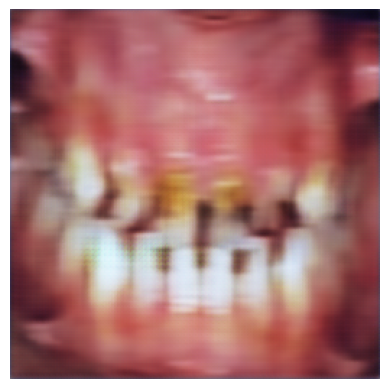

In [ ]:
#Pix2Pix Generate Motion Blurr Correction

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def generate_image(input_image_path, output_image_path, model_path):
    # Load the Pix2Pix model from .h5 file
    model = keras.models.load_model(model_path)

    # Preprocess the input data
    def preprocess_input(input_image):
        input_image = tf.cast(input_image, tf.float32)
        input_image = (input_image / 127.5) - 1.0  # Normalize between -1 and 1
        return input_image

    # Perform inference on new data
    def inference(input_image):
        # Preprocess input
        input_image = preprocess_input(input_image)

        # Add batch dimension and expand dimensions for model input
        input_image = tf.expand_dims(input_image, axis=0)

        # Generate output
        generated_image = model.predict(input_image)

        # Postprocess output
        generated_image = np.squeeze(generated_image, axis=0)
        generated_image = (generated_image + 1.0) * 127.5  # De-normalize

        return generated_image

    # Load and process the new data for inference
    new_data = keras.preprocessing.image.load_img(input_image_path, target_size=(256, 256))
    new_data = keras.preprocessing.image.img_to_array(new_data)

    # Perform inference
    output_image = inference(new_data)

    # Save the generated output image
    keras.preprocessing.image.save_img(output_image_path, output_image)

    # Display the processed image
    plt.imshow(output_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

# Example usage
input_image_path = '/content/blurred_image_rgb.jpg'
output_image_path = '/content/output_p2p_rgb.jpg'
#model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/xray - Generative Model - pix2pix/pix2pix_generator_model_DentalXray.h5'
model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/rgb camera - Generative Model - pix2pix/pix2pix_generator_model (1).h5'

generate_image(input_image_path, output_image_path, model_path)

In [ ]:
# Classification Dental Image RGB Camera

import numpy as np
from keras.models import load_model
import tensorflow as tf
from PIL import Image

def classify_image(image_path):
    # Load the model
    model = '/content/gdrive/MyDrive/Dental Disease/Trained Model/classification-camera-5class/dental_v1_vgg16.h5'
    model = tf.keras.models.load_model(model)

    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((256, 256))  # Resize the image to match the input size of the model
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    # Make predictions
    predictions = model.predict(img)

    # Get the predicted class labels
    class_labels = ['Gingivitis',
                    'Caries',
                    'Discoloration',
                    'Ulcer']

    # Print the predicted class probabilities
    for i, prob in enumerate(predictions[0]):
        label = class_labels[i]
        print(f"{label}: {prob * 100}%")

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label


image_path = '/content/11.jpg'

predicted_class = classify_image(image_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 609ms/step
Gingivitis: 13.819506764411926%
Caries: 84.23018455505371%
Discoloration: 1.948598399758339%
Ulcer: 0.0017093363567255437%
Predicted class: Caries


1/1 [==============================] - 1s 629ms/step
Gingivitis: 0.2533822553232312%
Caries: 68.71629357337952%
Discoloration: 29.475143551826477%
Ulcer: 1.5551764518022537%
Predicted class: Caries


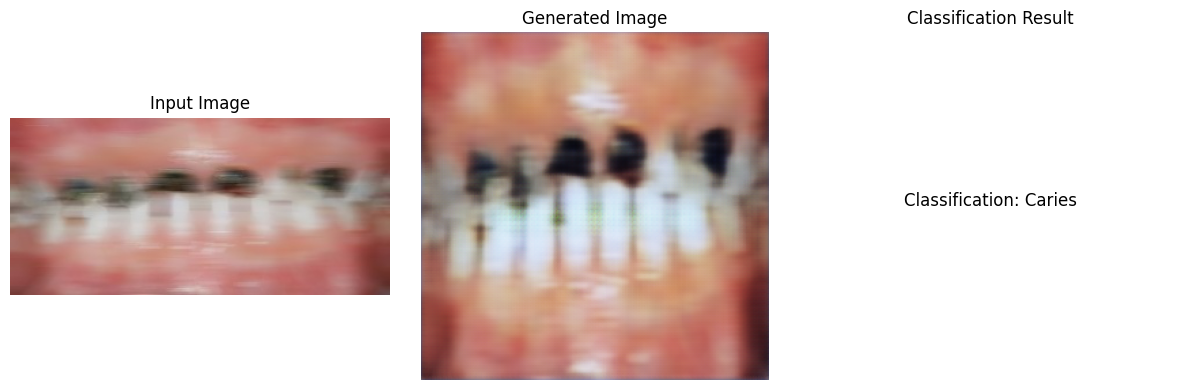

In [ ]:
# Class tahap 1

import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image

class ImageProcessing:
    def __init__(self, generator_model_path, classifier_model_path):
        self.generator_model = keras.models.load_model(generator_model_path)
        self.classifier_model = keras.models.load_model(classifier_model_path)
        self.class_labels = ['Gingivitis', 'Caries', 'Discoloration', 'Ulcer']

    def preprocess_input(self, input_image):
        input_image = tf.cast(input_image, tf.float32)
        input_image = (input_image / 127.5) - 1.0  # Normalize between -1 and 1
        return input_image

    def generate_image(self, input_image_path):
        # Load and process the input data
        input_image = Image.open(input_image_path)
        input_image = input_image.resize((256, 256))
        input_image = np.array(input_image)
        input_image = self.preprocess_input(input_image)

        # Add batch dimension and expand dimensions for model input
        input_image = tf.expand_dims(input_image, axis=0)

        # Generate output
        generated_image = self.generator_model.predict(input_image)

        # Postprocess output
        generated_image = np.squeeze(generated_image, axis=0)
        generated_image = (generated_image + 1.0) * 127.5  # De-normalize

        return generated_image

    def classify_image(self, image_path):
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize((256, 256))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0

        # Make predictions
        predictions = self.classifier_model.predict(img)

        # Print the predicted class probabilities
        for i, prob in enumerate(predictions[0]):
            label = self.class_labels[i]
            print(f"{label}: {prob * 100}%")

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the predicted class label
        predicted_class_label = self.class_labels[predicted_class_index]

        return predicted_class_label

    def process_image(self, input_image_path):
        # Generate the corrected image
        generated_image = self.generate_image(input_image_path)

        # Save the generated output image
        output_image_path = 'output_image.jpg'
        Image.fromarray(generated_image.astype(np.uint8)).save(output_image_path)

        # Perform image classification on the generated image
        predicted_class = self.classify_image(output_image_path)
        print("Predicted class:", predicted_class)

        # Display the images and classification result
        input_img = Image.open(input_image_path)
        generated_img = Image.fromarray(generated_image.astype(np.uint8))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_img)
        axes[0].axis('off')
        axes[0].set_title('Input Image')

        axes[1].imshow(generated_img)
        axes[1].axis('off')
        axes[1].set_title('Generated Image')

        axes[2].text(0.5, 0.5, f'Classification: {predicted_class}', fontsize=12, ha='center')
        axes[2].axis('off')
        axes[2].set_title('Classification Result')

        plt.tight_layout()
        plt.show()


# Example usage
generator_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/rgb camera - Generative Model - pix2pix/pix2pix_generator_model (1).h5'
classifier_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/classification-camera-5class/dental_v1_vgg16.h5'
input_image_path = '/content/blurred_image_rgb.jpg'

image_processor = ImageProcessing(generator_model_path, classifier_model_path)
image_processor.process_image(input_image_path)

### Gabungan

In [ ]:
import cv2

def is_grayscale(image):
    # Take the average value in each channel
    b, g, r = cv2.split(image)
    avg_b = b.mean()
    avg_g = g.mean()
    avg_r = r.mean()

    # Check the average value in each channel
    if avg_b == avg_g == avg_r:
      print("This is X-ray image")
    else:
      print("This is Color Image from Camera")


# Import Image
input_image_path = cv2.imread('/content/10.jpg')
is_grayscale(image)

This is Color Image from Camera
